# PDF Image Extraction Experimental notebook

---
Author: Phillipe Cardenuto ( RECOD - UNICAMP)

email: phillipe.cardenuto@ic.unicamp.br

---

## Instructions

Before running this notebook make sure to build the pdf-content-extraction docker
```
     $ cd docker && ./build.sh
```


During the experimental setup all PDF files from the dataset will be copy to a temporary
folder, named as `pdfs`, and all files will be renamed according to the PDF-KEY in the
`pdf-image-experimental-setup.json`.

Inside the JSON file, you will find the following structure:
```
PDF-KEY: {
  'Watermark' : <bool> # Indicates if the paper has a Retraction Watermark
  'pdf_path': 'dataset/path_to_pdf_file/.../pdf_file.pdf',
  'original_figures': {
                  'fig1': {
                     fig_path: 'dataset/path_to_pdf_figure_1/fig1.<ext>',
                     bbox_loc: {'p': <int>, 'x0': <int>, 'x1': <int>, 'y0': <int>, 'y1': <int>}
                       }
                         ...
                   'fign': {
                     fig_path: 'dataset/path_to_pdf_figure_n/fign.<ext>',
                     bbox_loc: {'p': <int>, 'x0': <int>, 'x1': <int>, 'y0': <int>, 'y1': <int>}
                        }
                         
                     }
}
```

Warning:
-------

This notebook uses the script `run_image_extraction.sh` to extract the image from a PDF file


Make sure to have this file in the same directory of this notebook

To Decrypt the PDFs file this notebook use an environment file named as '.env'.

Make sure to create this file in the same directory of this notebook, and include the following line, changing \<password\> by the real password
```bash
PDF_PASSWORD=<password>
```


# Requirements

You shouldn't have any issue after install the following
packages with pip
```
tqdm
scikit-image>=0.16
opencv-python>=3
python-dotenv
pymupdf  <-- used to decrypt pdf
```

# Code

In [4]:
# Import Library
from glob import glob
import shutil
import json
import subprocess
import os
import imghdr
from dotenv import load_dotenv
import fitz
# Some images were downloaded on  webp format
# We use opencv to convert them to png format
import cv2
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
def save_decrypted_pdf(src_name, dest_name):
    """
    Save a decrypted version of a pdf in 'dest_name'
    Make sure to have a .env file with the password on it.
    """
    doc = fitz.open(src_name)
    if doc.isEncrypted:
        load_dotenv()
        pdf_password = os.getenv('PDF_PASSWORD')
        if pdf_password is None:
            raise EnvironmentError("The password of the PDFs weren't correct insert in the '.env' file\n" +
                           "Create a file named as '.env' and include the following line:\n" +
                            "PDF_PASSWORD=<password>")
        doc.authenticate(pdf_password)
        doc.save(dest_name)
    else:
        doc.save(dest_name)
def extract_image(pdf_file, output_path='.'):
    cmd = f'./run_image_extraction.sh {pdf_file} {output_path}'
    result = subprocess.run(cmd,shell=True,stdout=subprocess.PIPE)
    return result.stdout.decode('utf-8')
def image_extension_correction(fig):
    """
    Some images were downloaded on  webp format
    We use opencv to convert them to png format
    """
    # Get img extension name
    ext = imghdr.what(fig)
    
    # If imghdr was not able to get the extension
    if ext is None:
        return fig
    
    if ext == "webp":
        # Convert image to png due to error with io.imread
        img = cv2.imread(fig)
        write_name = fig[:fig.rfind('.')] +".png" 
        cv2.imwrite(write_name,img)
        os.remove(fig)
        return write_name
    
    write_name = fig[:fig.rfind('.')] +"."+ ext
    os.rename(fig,write_name)
    return write_name

## Testing the extraction for samples file

In [3]:
# Creates the folder test
os.makedirs('test/')
# Run simple tests
sample_1 = extract_image('sample_1.pdf','test/')
print(sample_1)
sample_2 = extract_image('sample_2.pdf','test/')
print(sample_2)

sample_1.pdf
/INPUT/sample_1.pdf
Extraction Done!

sample_2.pdf
/INPUT/sample_2.pdf
Extraction Done!



# Experiment setup

In [66]:
# Load the json file to a variable
with open('pdf-image-experimental-setup.json','r') as json_pointer:
    exp_setup = json.load(json_pointer)

In [69]:
# Creates the folder pdfs
os.makedirs('pdfs',exist_ok=True)

# Copy All files to a temporary folder
pdfs = []
total_docs = len(exp_setup)
for keyname, value in tqdm(exp_setup.items(), total=total_docs):
    
    # Copy PDF to path pdfs with the name of its ID
    pdf_keyname = f'pdfs/{keyname}.pdf'
    src_name = value['pdf_path']
    # Save a decrypted version of the pdf
    save_decrypted_pdf(src_name,pdf_keyname)
    
    pdfs.append(pdf_keyname)
    
    # Copy PDF figures to path figures/<PDF_ID>/<figname>
    fig_dest = f'figures/{keyname}'
    os.makedirs(fig_dest,exist_ok=True)
    for fig_key, fig_value in value['original_figures'].items():
        dest = fig_dest+"/"+ os.path.basename(fig_value['fig_path'])
        shutil.copy(fig_value['fig_path'], dest)
        image_extension_correction(dest)
    

# Run Method

In [70]:
# Extracte figures from the pdfs at ./pdfs
# messages carry all outputs messages of running method
messages = process_map(extract_image,pdfs)

# Evaluate Method

In [71]:
# import modules to evaluate
from skimage import io
from skimage.color import gray2rgb, rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
import os
from glob import glob
import numpy as np 

# Define SSIM function

## Declare Auxilary function and parameters for evaluation

In [102]:
MATCH_THRESH = 0.55
USE_CW_SSIM = True
USE_ORIGINAL_SIZE = False
RESIZE = (128, 128)
def computeSSIM(resImage, dataImage):
    """
    This function computes the ssim score given the two images. 
    Note that, if the shape of the two images don't match, 
    it will resize the result image to the same size as data image. 

    Params:     
        resImage: 2d numpy array
        dataImage: 2d numpy array
    Return: 
        score: float or None
    """
    if resImage is None or dataImage is None: 
        return None
    
    if len(resImage.shape) != len(dataImage.shape): # color vs. gray
        if len(resImage.shape) == 2 and len(dataImage.shape) == 3: 
            resImage = gray2rgb(resImage)
        elif len(resImage.shape) == 3 and len(dataImage.shape) == 2: 
            resImage = rgb2gray(resImage)
        else:                
            return None
        
    if dataImage.shape[-1] == 4:
            dataImage = rgba2rgb(dataImage)
    if resImage.shape[-1] == 4:
            resImage = rgba2rgb(resImage)
    
    if USE_ORIGINAL_SIZE and not (np.array(resImage.shape) == np.array(dataImage.shape)).all(): # size 
        h, w = dataImage.shape[:2]
        resImage = cv2.resize(resImage, (w, h), interpolation=cv2.INTER_CUBIC)
    elif not USE_ORIGINAL_SIZE: 
        resImage = cv2.resize(resImage, RESIZE, interpolation=cv2.INTER_CUBIC)
        dataImage = cv2.resize(dataImage, RESIZE, interpolation=cv2.INTER_CUBIC)
    return ssim(resImage, dataImage, multichannel=len(dataImage.shape) == 3)

def get_fignumber(fig):
    return os.path.basename(fig).split(".")[0]

def get_loc_from_fig_path(fig_path):
    fig_path = os.path.basename(fig_path)
    fig_path = fig_path.replace("--",'-')
    info = fig_path.split('-')
    return {
        'p': int(info[1]),
        'x0': int(float(info[3])),
        'y0': int(float(info[5])),
        'x1': int(float(info[7])),
        'y1': int(float(info[9]))
    }
def has_intersection(a, b):
    """
    Verify if the inputs regions has any intersection
    """
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0] + a[2], b[0] + b[2]) - x
    h = min(a[1] + a[3], b[1] + b[3]) - y
    if w < 0 or h < 0:
        return False
    return True

def check_intersection(loc_annotation, loc_extraction):
    """
    Check if the image from the annotation has intersection
    with the extracted image
    """
    if int(loc_annotation['p']) != int(loc_extraction['p']):
        return False
    
    bbox_extraction = (int(loc_extraction['x0']),
                       int(loc_extraction['y0']),
                       int(loc_extraction['x1']),
                       int(loc_extraction['y1']))
    
    bbox_annotation = (int(loc_annotation['x0']),
                       int(loc_annotation['y0']),
                       int(loc_annotation['x1']),
                       int(loc_annotation['y1']))
    return has_intersection(bbox_extraction, bbox_annotation)

# Run Evaluation loop

Evaluate the image extraction for each PDF from the experimental setup

All the pdf_scores will be stored in a json format carrying
```
PDF-INDEX{

    'mean_ssim': <float> # The mean of all SSIM scores from of each figure
    'std_ssim': <float> # Standard deviation of all SSIM scores from of each figure
    'fig1': { 'match': <path_to_img_extracted>  #path to image that matched with fig1
              'score': <float>    # SSIM score between fig1 and its match
            }
    ...
    'figN': {
            'match': <path_to_img_extracted>
            'score': <float>
        }
}
```

In [116]:
# Intialize pdf_scores
pdf_scores = {}

# loop all result images 
for pdf_id in tqdm(exp_setup.keys()): 
    
    # Load originals and extracted imgs paths 
    xfigs = glob(f"xfigs/{pdf_id}/*")
    orig_figs = sorted(glob(f"figures/{pdf_id}/*"))
    
    # Initialize pdf_score dict for pdf_id
    pdf_scores[pdf_id] = { get_fignumber(fig): {"match": "", 'score': 0}
                          for fig in orig_figs
                         }
    
    # if the method does't extract anything                   
    if len(xfigs)==0:
        pdf_scores[pdf_id]['mean_ssim'] = 0
        pdf_scores[pdf_id]['std_ssim'] = 0
        continue
        
    # Load extracted figs using list of tuples (img, path)
    xfigs_xpath = [(io.imread(xfig),xfig) for xfig in xfigs]

    # compare each original figure with all extracted images
    for orig_path in orig_figs: 
        orig = io.imread(orig_path)
        orig_fig_number = get_fignumber(orig_path)
        
        # get the figure bbox (page,x0,y0,x1,y1)
        orig_fig_loc = exp_setup[pdf_id]['original_figures'][orig_fig_number]['bbox_loc']
        
        # Initialize final score for the image
        final_score = 0
        final_match = ""
        
        # Run through all xfigs, trying a match with the orig_fig
        for xfig, xpath  in xfigs_xpath:
            
            xfig_loc = get_loc_from_fig_path(xpath)
            # If it has a location match coumpute SSIM
            if check_intersection(orig_fig_loc, xfig_loc):
                score = computeSSIM(xfig, orig)
                
                if score is not None and score > final_score: 
                    final_score = score
                    final_match = xpath
                
        # Update score info
        pdf_scores[pdf_id][get_fignumber(orig_path)]['match'] = final_match
        pdf_scores[pdf_id][get_fignumber(orig_path)]['score'] = final_score
    
    # Compute a the mean and std ssim for the pdf
    scores = np.array([ pdf_scores[pdf_id][fig]['score'] for fig in pdf_scores[pdf_id].keys()]) *100
    pdf_scores[pdf_id]['mean_ssim'] = np.mean(scores)
    pdf_scores[pdf_id]['std_ssim'] = np.std(scores)

/home/jcardenuto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
/home/jcardenuto/anaconda3/lib/python3.6/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/home/jcardenuto/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


# Plot Score

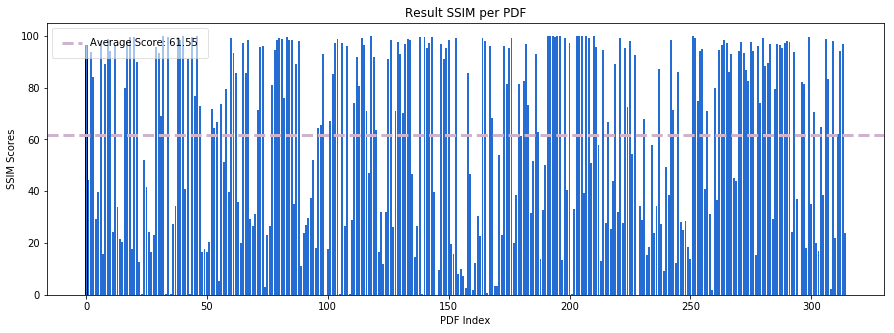

Score: 62 +/- 35


In [160]:
y = np.array(means)
x = np.arange(len(means))

plt.figure(figsize=(15,5))
# plt.hist(y, bins=np.arange(0,100,1),facecolor='#266DD3',edgecolor='black')
plt.axhline(y.mean(), color='#CFB3CD', linestyle='dashed', linewidth=3,label=f'Average Score: {y.mean():.2f}')
plt.bar(x, means, facecolor='#266DD3',edgecolor='black')
# plt.scatter(x,means)
plt.title("Result SSIM per PDF")
plt.xlabel('PDF Index')
plt.ylabel("SSIM Scores")
plt.legend(fancybox=True, framealpha=0.6, borderpad=1)

plt.show()

print(f"Score: {y.mean():.0f} +/- {y.std():.0f}")